In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
data=pd.read_csv("Womens Clothing E-Commerce Reviews.csv")

In [3]:
data.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [4]:
data.fillna(" ",inplace=True)

In [5]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia=SentimentIntensityAnalyzer()

In [6]:
def polarity(text):
    score=sia.polarity_scores(text)
    if score["compound"]>0.05:
        return "positive"
    if score["compound"]<0:
        return "negative"
    else :
        return "neutral"

In [41]:
data["combined_title_review"]=data["Title"]+' '+data["Review Text"]
data["score"]=data["combined_title_review"].apply(polarity)

### EDA

In [43]:
print(f"Total Reviews: {len(data)}")

Total Reviews: 23486


In [44]:
print(f"Columns: {data.columns.tolist()}")

Columns: ['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating', 'Recommended IND', 'Positive Feedback Count', 'Division Name', 'Department Name', 'Class Name', 'combined_title_review', 'score']


In [45]:
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
Unnamed: 0                 0
Clothing ID                0
Age                        0
Title                      0
Review Text                0
Rating                     0
Recommended IND            0
Positive Feedback Count    0
Division Name              0
Department Name            0
Class Name                 0
combined_title_review      0
score                      0
dtype: int64


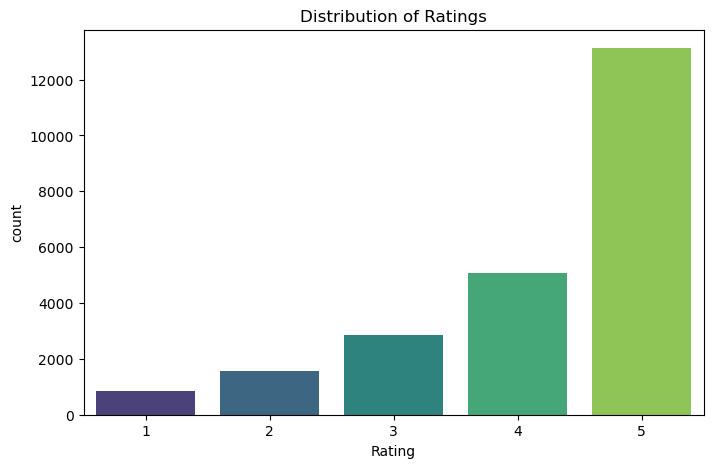

In [46]:
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='Rating', palette='viridis')
plt.title("Distribution of Ratings")
plt.show()

Text(0.5, 1.0, 'Sentiment Distribution (Positive/Neutral/Negative)')

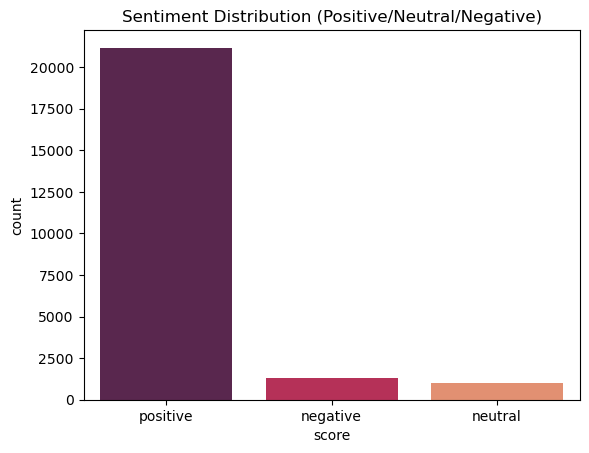

In [48]:
sns.countplot(data=data, x='score', palette='rocket')
plt.title("Sentiment Distribution (Positive/Neutral/Negative)")

C:\Users\salma\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Distribution of Review Length (Words)')

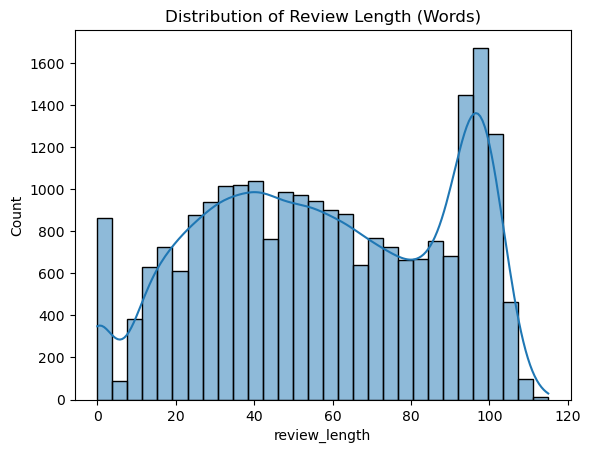

In [49]:
data['review_length'] = data['Review Text'].apply(lambda x: len(str(x).split()))
sns.histplot(data=data, x='review_length', bins=30, kde=True)
plt.title("Distribution of Review Length (Words)")

Text(0.5, 1.0, 'Age Distribution by Rating')

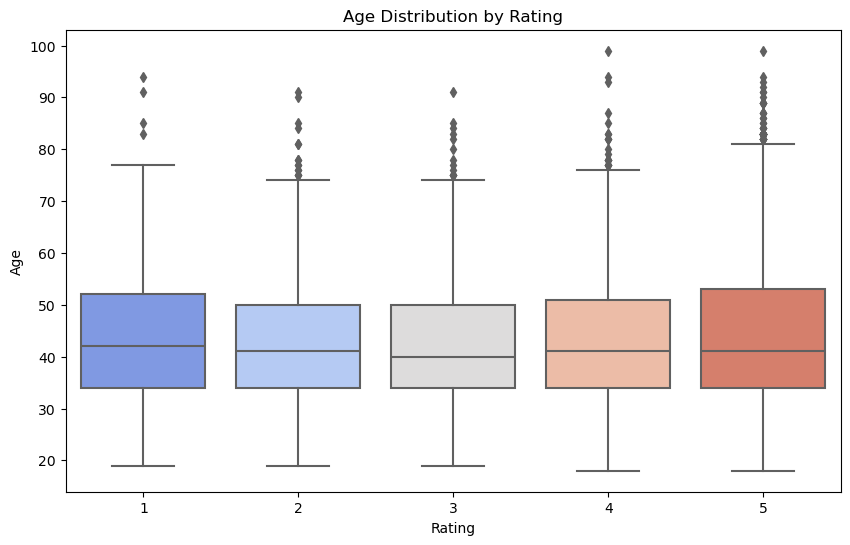

In [50]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='Rating', y='Age', palette='coolwarm')
plt.title("Age Distribution by Rating")

AttributeError: 'numpy.int64' object has no attribute 'startswith'

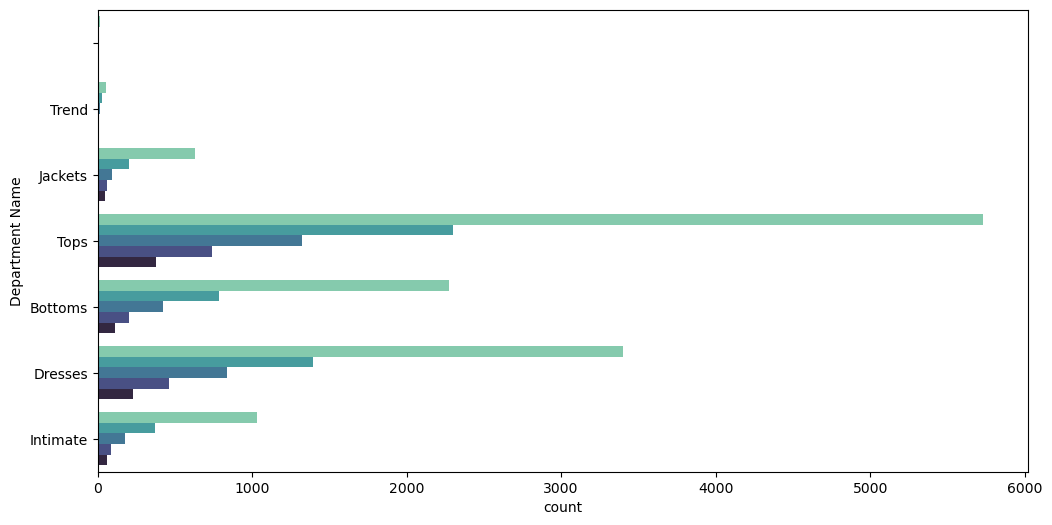

In [52]:
plt.figure(figsize=(12, 6))
sns.countplot(data=data, y='Department Name', hue='Rating', palette='mako')
plt.title("Rating Distribution by Department")
plt.show()

In [54]:
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


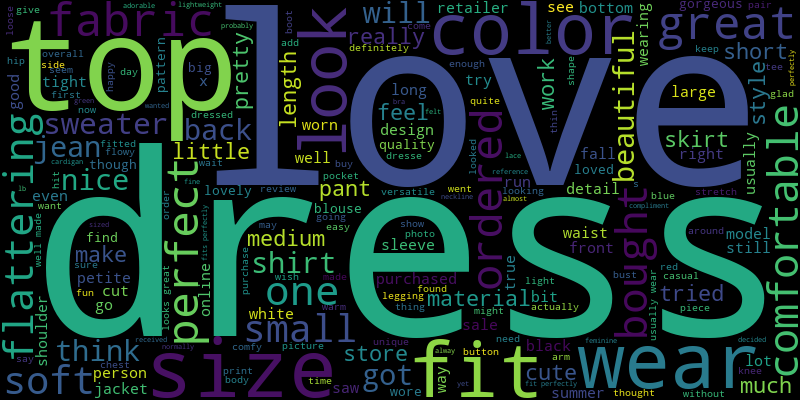

In [55]:
from wordcloud import WordCloud

positive_reviews = ' '.join(data[data['Rating'] >= 4]['Review Text'])
negative_reviews = ' '.join(data[data['Rating'] <= 2]['Review Text'])

# Positive Word Cloud
WordCloud(width=800, height=400).generate(positive_reviews).to_image()

<Axes: >

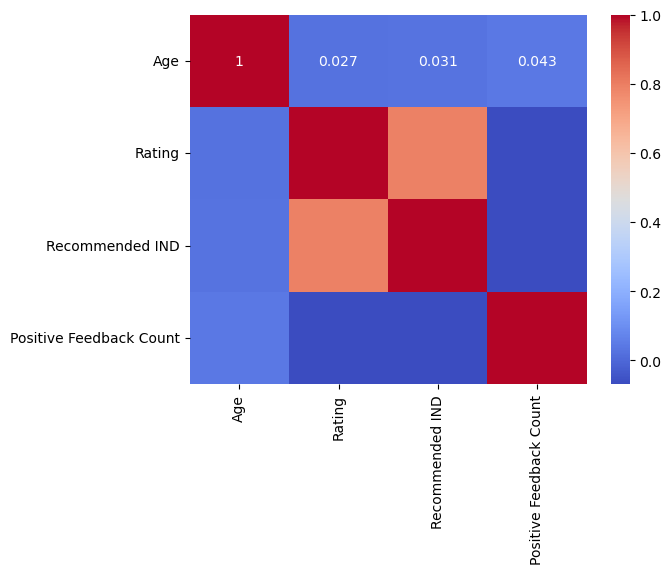

In [56]:
numeric_data = data[['Age', 'Rating', 'Recommended IND', 'Positive Feedback Count']]
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')

### train test split

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [9]:
data["score"]=np.where(data["score"]=="positive",1,0)
x=data['combined_title_review']
y=data['score']

In [10]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25)

In [11]:
vectoriser=TfidfVectorizer()
x_train=vectoriser.fit_transform(x_train)
x_test=vectoriser.transform(x_test)

In [12]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(
    penalty='l2',  # Regularization
    C=1.0,  # Inverse of regularization strength
    solver='liblinear',  # Good for small datasets
    max_iter=1000
)

In [13]:
model.fit(x_train,y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [14]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(x_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.9465258855585831
              precision    recall  f1-score   support

           0       0.92      0.49      0.64       567
           1       0.95      1.00      0.97      5305

    accuracy                           0.95      5872
   macro avg       0.93      0.74      0.81      5872
weighted avg       0.95      0.95      0.94      5872



### SMOTE

In [15]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(x_train, y_train)

In [16]:
X_resampled.shape, y_resampled.shape

((31718, 12964), (31718,))

In [17]:
model.fit(X_resampled, y_resampled)

LogisticRegression(max_iter=1000, solver='liblinear')

In [18]:
x_test, y_test=ros.fit_resample(x_test, y_test)

In [19]:
y_pred = model.predict(x_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8820923656927427
              precision    recall  f1-score   support

           0       0.91      0.85      0.88      5305
           1       0.86      0.92      0.89      5305

    accuracy                           0.88     10610
   macro avg       0.88      0.88      0.88     10610
weighted avg       0.88      0.88      0.88     10610



### saving models

In [24]:
import joblib
joblib.dump(model,"ML_model.joblib")
joblib.dump(vectoriser,"vectoriser.joblib")

['vectoriser.joblib']

In [26]:
ml=joblib.load("ML_model.joblib")
vc=joblib.load("vectoriser.joblib")

In [39]:
def predicting(words):
    testing =vc.transform([words])
    prediction = ml.predict(testing)
    if prediction[0]==1:
        return "positive review"
    if prediction[0]==0:
        return "not positive review"

### predicting

In [58]:
text="The dress quality is amazing!"
predicting(text)

'positive review'